In [ ]:
# Model definition and training

In [76]:
# Loading Libraries
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout


In [184]:
# Import libraries
import numpy as np
import pandas as pd

# Import matplotlib to load, view, and test unseen plume & no-plume images from the larger plume and dummy directories
import matplotlib.pyplot as plt



In [185]:
# Read preprocessed tabular files
plume_list = pd.read_csv('permian_plume_list_2019_facility_sector_oldpng_and_ctr_tif_names_pers_conf_with_newPNG_names.csv')
plume_list.drop(labels = ['Unnamed: 0', 'Unnamed: 0.1'], axis = 1, inplace = True)
plume_list.head()

,Unnamed: 0.2,source_id,plume_lat,plume_lon,candidate_id,date,time,qplume,sigma_qplume,active_flair_detected,inactive_flair_detected,file_name,type,ipcc_sector,new_rgb_file_name,new_ctr_file_name,source_persistence,confidence_in_persistence,new_png_file_name
0,0,P00001,32.212063,-103.697076,ang20190922t192642-2,2019-09-22,19:26:42,2579.528100,902.732655,False,False,ang20190922t192642-2_r4578_c217-plume.png,tank,1B2 Oil & Natural Gas,ang20190922t192642-2_r4578_c217_rgb.tif,ang20190922t192642-2_r4578_c217_ctr.tif,0.833333,0.968324,ang20190922t192642-2_r4578_c217_.png
1,1,P00002,32.200072,-103.673301,ang20190922t192642-4,2019-09-22,19:26:42,420.725207,147.155782,False,False,ang20190922t192642-4_r4928_c373-plume.png,tank,1B2 Oil & Natural Gas,ang20190922t192642-4_r4928_c373_rgb.tif,ang20190922t192642-4_r4928_c373_ctr.tif,0.333333,0.968324,ang20190922t192642-4_r4928_c373_.png
2,2,P00003,32.116008,-103.626345,ang20190922t192642-5,2019-09-22,19:26:42,1051.909600,339.267587,False,False,ang20190922t192642-5_r6423_c113-plume.png,tank,1B2 Oil & Natural Gas,ang20190922t192642-5_r6423_c113_rgb.tif,ang20190922t192642-5_r6423_c113_ctr.tif,0.583333,0.968324,ang20190922t192642-5_r6423_c113_.png
3,3,P00004,32.322594,-103.816072,ang20190922t194340-1,2019-09-22,19:43:40,1736.644250,1035.427670,False,False,ang20190922t194340-1_r1953_c438-plume.png,pipeline,1B2 Oil & Natural Gas,ang20190922t194340-1_r1953_c438_rgb.tif,ang20190922t194340-1_r1953_c438_ctr.tif,0.090909,0.957765,ang20190922t194340-1_r1953_c438_.png
4,4,P00005,32.284083,-103.793989,ang20190922t194340-2,2019-09-22,19:43:40,870.605019,435.968147,False,False,ang20190922t194340-2_r2642_c324-plume.png,tank,1B2 Oil & Natural Gas,ang20190922t194340-2_r2642_c324_rgb.tif,ang20190922t194340-2_r2642_c324_ctr.tif,0.200000,0.943686,ang20190922t194340-2_r2642_c324_.png


## Data preprocessing

In [186]:
# How many entries do we have ?
plume_list.shape

(3067, 19)

In [187]:
# Defining relative uncertainty value
plume_list['Sigma_percent'] = plume_list['sigma_qplume'] / plume_list['qplume']

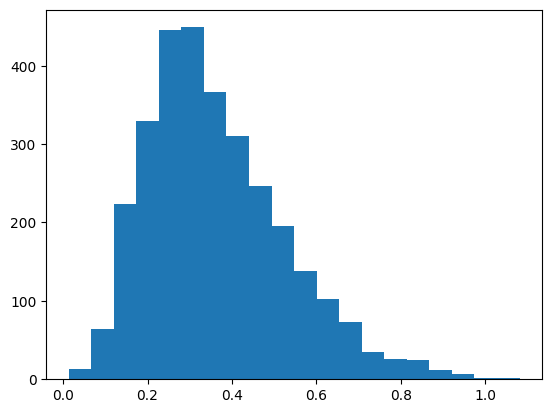

In [188]:
# Looking at the distribution of the relative uncertainty in the emission rates
plt.hist(plume_list['Sigma_percent'], bins = 20)
plt.show()

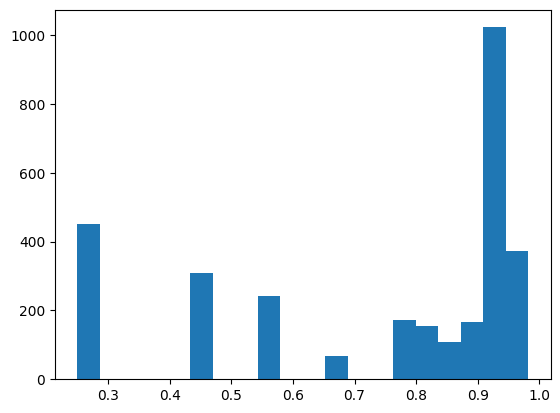

In [189]:
# Reduce by low confidence values
plt.hist(plume_list['confidence_in_persistence'], bins = 20)
plt.show()

In [190]:
# Preprocessing data by filtering out values with low confidence in persistence and relative uncertainty. Also removing outliers.
reduced_plume = plume_list[plume_list['confidence_in_persistence'] > 0.5]
reduced_plume = reduced_plume[reduced_plume['qplume'] < 10000]
reduced_plume = reduced_plume[reduced_plume['Sigma_percent'] <= 0.50].reset_index()
reduced_plume.shape

(1834, 21)

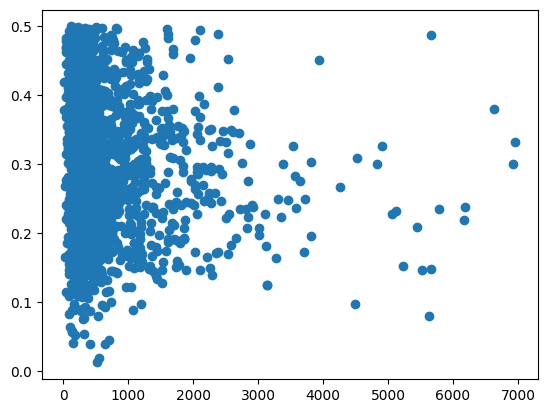

In [191]:
plt.scatter(reduced_plume['qplume'],  reduced_plume['Sigma_percent'])
plt.show()

In [192]:
reduced_plume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1834 entries, 0 to 1833
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      1834 non-null   int64  
 1   Unnamed: 0.2               1834 non-null   int64  
 2   source_id                  1834 non-null   object 
 3   plume_lat                  1834 non-null   float64
 4   plume_lon                  1834 non-null   float64
 5   candidate_id               1834 non-null   object 
 6   date                       1834 non-null   object 
 7   time                       1834 non-null   object 
 8   qplume                     1834 non-null   float64
 9   sigma_qplume               1834 non-null   float64
 10  active_flair_detected      1834 non-null   bool   
 11  inactive_flair_detected    1834 non-null   bool   
 12  file_name                  1834 non-null   object 
 13  type                       1802 non-null   objec

In [193]:
reduced_plume.tail()

,index,Unnamed: 0.2,source_id,plume_lat,plume_lon,candidate_id,date,time,qplume,sigma_qplume,...,inactive_flair_detected,file_name,type,ipcc_sector,new_rgb_file_name,new_ctr_file_name,source_persistence,confidence_in_persistence,new_png_file_name,Sigma_percent
1829,3029,3029,P01765,32.036268,-103.64578,GAO20191102t203238p0000-D,2019-11-02,20:32:38,395.727756,127.027045,...,False,GAO20191102t203238p0000-D_r6413_c771-plume.png,compressor,1B2 Oil & Natural Gas,GAO20191102t203238p0000-D_r6413_c771_rgb.tif,GAO20191102t203238p0000-D_r6413_c771_ctr.tif,0.090909,0.957765,GAO20191102t203238p0000-D_r6413_c771_.png,0.320996
1830,3030,3030,P01766,32.051851,-103.61351,GAO20191102t203238p0000-E,2019-11-02,20:32:38,265.379184,62.748732,...,False,GAO20191102t203238p0000-E_r6118_c1275-plume.png,tank,1B2 Oil & Natural Gas,GAO20191102t203238p0000-E_r6118_c1275_rgb.tif,GAO20191102t203238p0000-E_r6118_c1275_ctr.tif,0.083333,0.968324,GAO20191102t203238p0000-E_r6118_c1275_.png,0.236449
1831,3054,3054,P01787,32.756723,-104.21299,GAO20191103t182306p0000-D,2019-11-03,18:23:06,425.832980,111.621535,...,False,GAO20191103t182306p0000-D_r6488_c860-plume.png,tank,1B2 Oil & Natural Gas,GAO20191103t182306p0000-D_r6488_c860_rgb.tif,GAO20191103t182306p0000-D_r6488_c860_ctr.tif,0.333333,0.578125,GAO20191103t182306p0000-D_r6488_c860_.png,0.262125
1832,3061,3061,P01794,32.779638,-104.26515,GAO20191103t185130p0000-A,2019-11-03,18:51:30,381.719343,150.917383,...,False,GAO20191103t185130p0000-A_r6709_c487-plume.png,tank,1B2 Oil & Natural Gas,GAO20191103t185130p0000-A_r6709_c487_rgb.tif,GAO20191103t185130p0000-A_r6709_c487_ctr.tif,0.333333,0.578125,GAO20191103t185130p0000-A_r6709_c487_.png,0.395362
1833,3065,3065,P01795,32.777258,-104.27985,GAO20191103t190631p0000-C,2019-11-03,19:06:31,282.037503,117.607741,...,False,GAO20191103t190631p0000-C_r7026_c574-plume.png,tank,1B2 Oil & Natural Gas,GAO20191103t190631p0000-C_r7026_c574_rgb.tif,GAO20191103t190631p0000-C_r7026_c574_ctr.tif,0.333333,0.578125,GAO20191103t190631p0000-C_r7026_c574_.png,0.416993


In [194]:
# Creating bins to classify entries into categories
reduced_plume['bin'] = reduced_plume['qplume']/500
reduced_plume['bin'] = reduced_plume['bin'].astype(int)

In [195]:
reduced_plume['bin'].max(), reduced_plume['bin'].min()

(13, 0)

In [196]:
# Setting the bins values above 5 in the same bin
for val in range(6,13):
    reduced_plume['bin'].replace(val, 5, inplace = True)
    print(val)


6
7
8
9
10
11
12


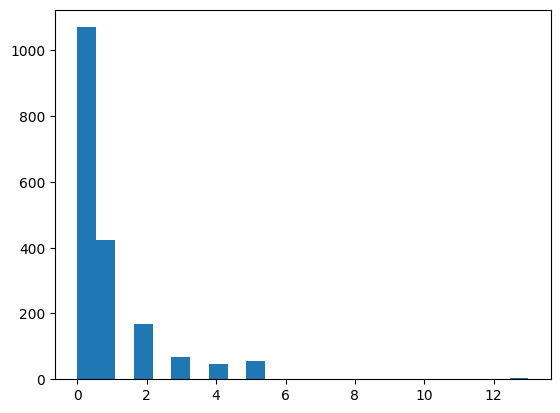

In [197]:
plt.hist( reduced_plume['bin'], bins = 24)
plt.show()

In [198]:
q_bin = reduced_plume['bin']

In [199]:
# imitiate an empty np array
NumImages = len(reduced_plume)
#image_set = np.zeros((NumImages,217,217,4))
#NumImages = 500
image_set = np.zeros((NumImages,160,160,4))

In [200]:
reduced_plume['new_ctr_file_name'].tail()

1829     GAO20191102t203238p0000-D_r6413_c771_ctr.tif
1830    GAO20191102t203238p0000-E_r6118_c1275_ctr.tif
1831     GAO20191103t182306p0000-D_r6488_c860_ctr.tif
1832     GAO20191103t185130p0000-A_r6709_c487_ctr.tif
1833     GAO20191103t190631p0000-C_r7026_c574_ctr.tif
Name: new_ctr_file_name, dtype: object

In [201]:
from PIL import Image

In [202]:
def Resize(Path, Size):
    img1 = Image.open(Path)
    img1 = img1.resize(Size)
    img1 = np.asarray(img1)/255
    return img1

In [203]:
# Other method to remove background in images with an empirical approach. Not used

def Resize_Filter_for_RedandPurple_Plume(Path, Size, color):
    a, b = 0, 3
    img1 = Image.open(Path)
    img1 = img1.resize(Size)
    img1 = np.asarray(img1)/255
    #Red Plume Processing
    if color == 'red':
        img1[:,:,b] = np.multiply(img1[:,:,b] ,  img1[:,:,a] >= 0.95  )
        return img1
    #Purple Plume Processing
    else:
        img2 = Image.open(Path)
        img2 = img2.resize(Size)
        img2 = np.asarray(img2)/255
        img3 = Image.open(Path)
        img3 = img3.resize( Size)
        img3 = np.asarray(img3)/255       
       
        #Capture Red
        img3[:,:,b] = np.multiply(img3[:,:,b] ,  img3[:,:,a] >= 0.95  )
        #Capture green / yellow 
        img1[:,:,b] = np.multiply(img1[:,:,b] ,  img1[:,:,a+1] >= 0.8  )
        #print(img1.shape)
        img1[:,:,b] = np.multiply( img1[:,:, b] ,  img1[:,:,a+1] <= 0.9 )
        #print(img1.shape)
        #Capture Purple
        img2[:,:,b] = img2[:,:, b] * ( img2[:,:,a+2] >= 0.75 )
        # Merge
        img2[:,:,b] = img2[:,:,b] * (img2[:,:,b] > img1[:,:,b] ) + img1[:,:,b] * (img1[:,:,b] > img2[:,:,b]) + img2[:,:,b] * (img2[:,:,b] == img1[:,:,b])
    
        img3[:,:,b] = img2[:,:,b] * (img2[:,:,b] > img3[:,:,b] ) + img3[:,:,b] * (img3[:,:,b] > img2[:,:,b]) + img2[:,:,b] * (img2[:,:,b] == img3[:,:,b])

        return img3

In [204]:
path = 'Purple_Plumes/permian_2019/permian_2019_rgb_ctr/' + reduced_plume['new_ctr_file_name'].loc[0]
img1 = Image.open(path)
img1 = img1.resize((160,160))
img1 = np.asarray(img1)/255
print(img1.shape)
plt.imshow(img1)
plt.xlabel(str(int(reduced_plume['qplume'].loc[0])), fontsize = 12 )
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'Purple_Plumes/permian_2019/permian_2019_rgb_ctr/ang20190922t192642-2_r4578_c217_ctr.tif'

Sample of Loaded and Filtered Image set for Plume, shape is  (1834, 160, 160, 4)


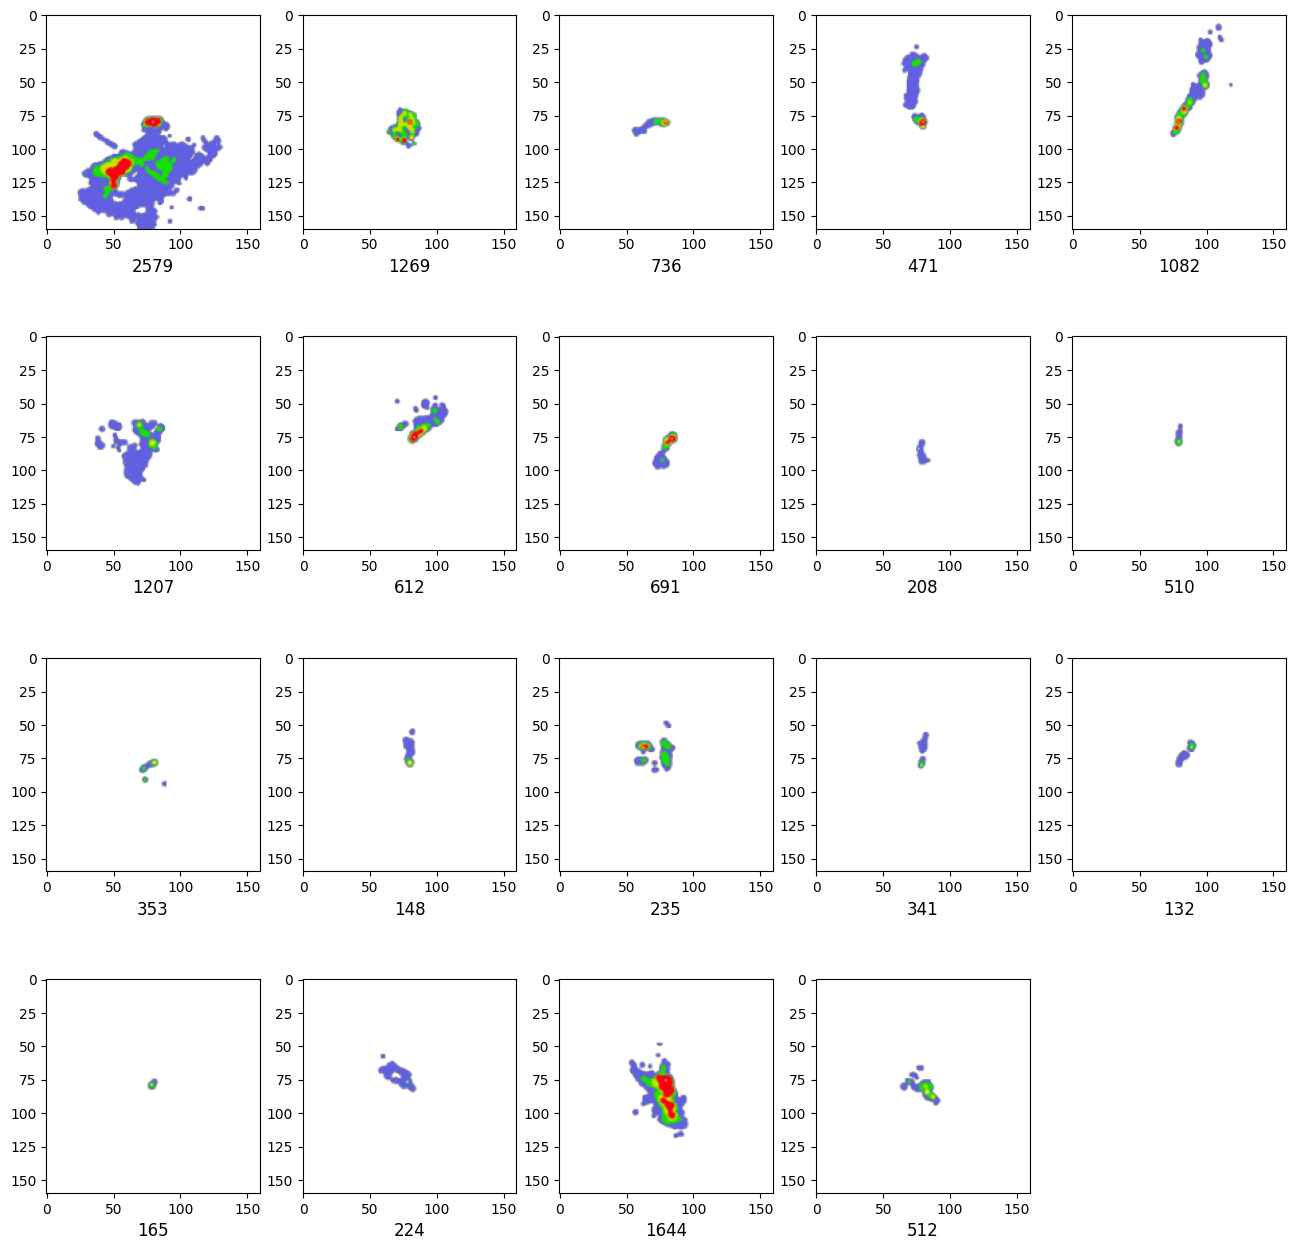

In [206]:
# Read image files into the np array with resizing
i = 0
plt.figure(figsize=(16,16))
for j in range(NumImages):
    path = 'support_data/permian_2019/permian_2019/' + reduced_plume['new_ctr_file_name'].loc[j]
    image_set[j] =  Resize(path, (160,160))
    
    if j%100 == 0:
        plt.subplot(4,5,i+1)
        plt.imshow(image_set[j])
        plt.xlabel(str(int(reduced_plume['qplume'].loc[j])), fontsize = 12 )
        i += 1
    else:
        pass
    
print('Sample of Loaded and Filtered Image set for Plume, shape is ',image_set.shape)
plt.show()

In [207]:
# Read image files into the np array
i = 0
plt.figure(figsize=(16,16))
for j in range(19):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_set[j*100])
    plt.xlabel(str(int(reduced_plume['qplume'].loc[j*100])), fontsize = 18 )   
    i += 1
print('Corresponding Filtered Images ',image_set.shape)
plt.show

Corresponding Filtered Images  (1834, 160, 160, 4)


<function matplotlib.pyplot.show(close=None, block=None)>

In [208]:
#Get scaler values based on the entire dataset
Qs = np.array(reduced_plume['qplume'])

In [209]:
Qs = np.power(Qs, (3/4))

In [210]:
# Scaling the target values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [211]:
scaler.fit(Qs.reshape(-1,1))

MinMaxScaler()

In [212]:
y = np.array(np.power(reduced_plume['qplume'], (3/4)) )
y = scaler.fit_transform(y.reshape(-1,1))

In [213]:
from pickle import dump

In [214]:
dump(scaler, open('scaler_rev13CTR.pkl', 'wb'))

In [215]:
image_set.shape, len(y)

((1834, 160, 160, 4), 1834)

In [216]:
y[0:5]

array([[0.46887001],
       [0.11144039],
       [0.23340577],
       [0.17909113],
       [0.39342816]])

In [217]:
# Convert from RGBA to RGB - remove the opacity layer
#image_set = image_set[:,:,:,0:3]
# KEEP IMAGE SET AT SHAPE 4

Image Preview and Plume Rate


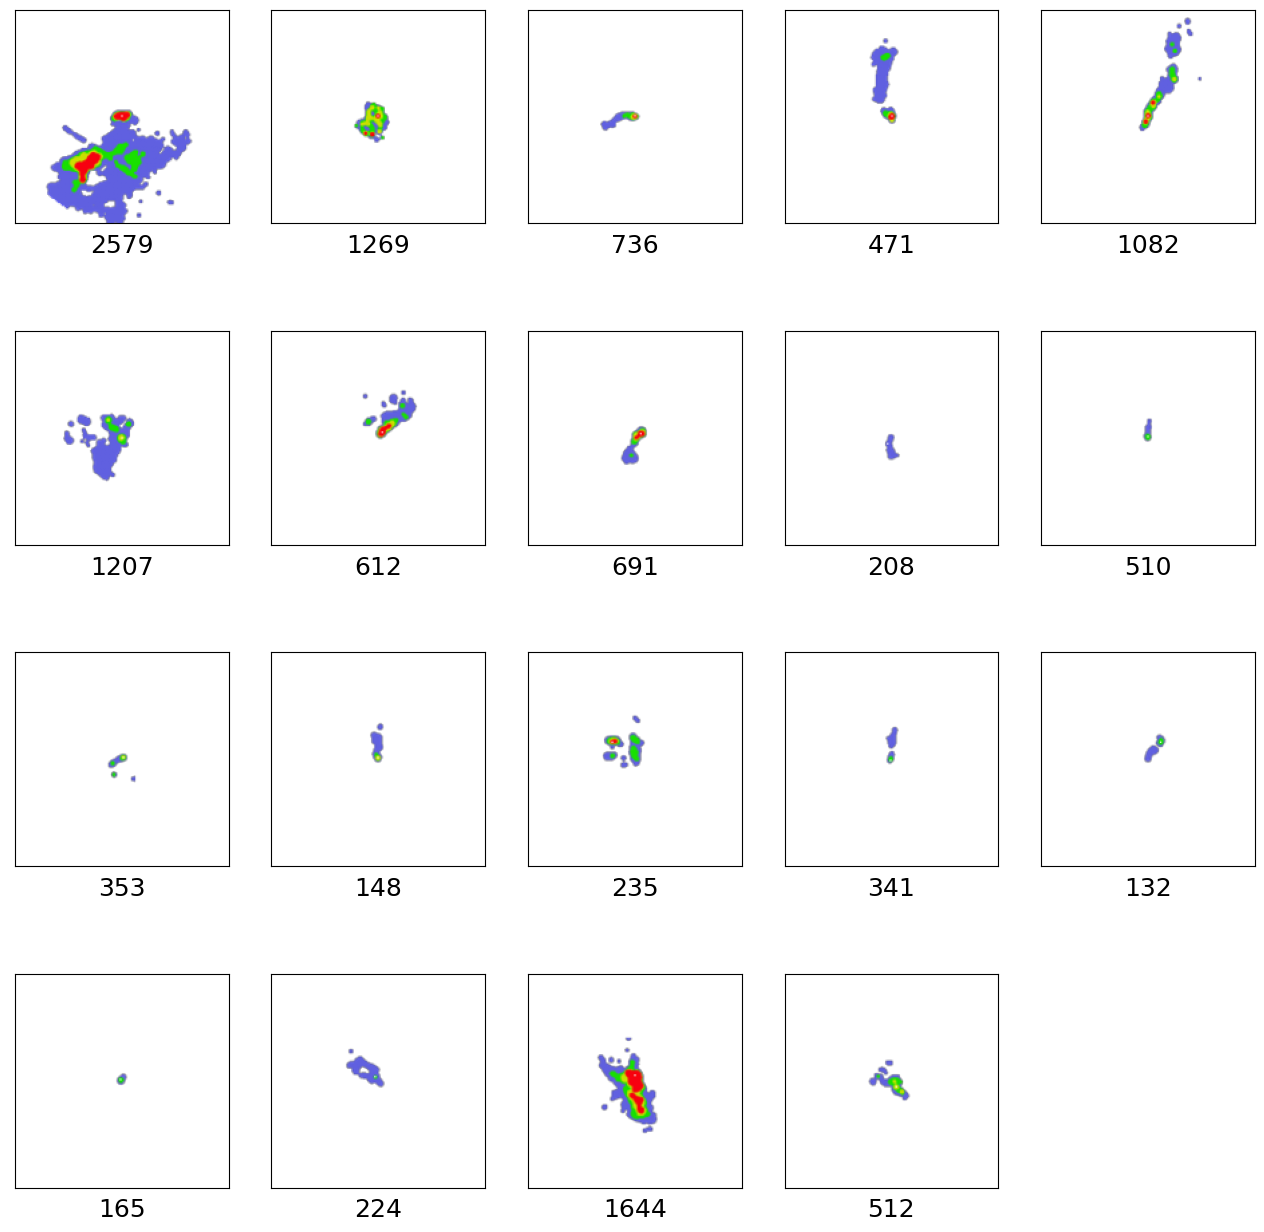

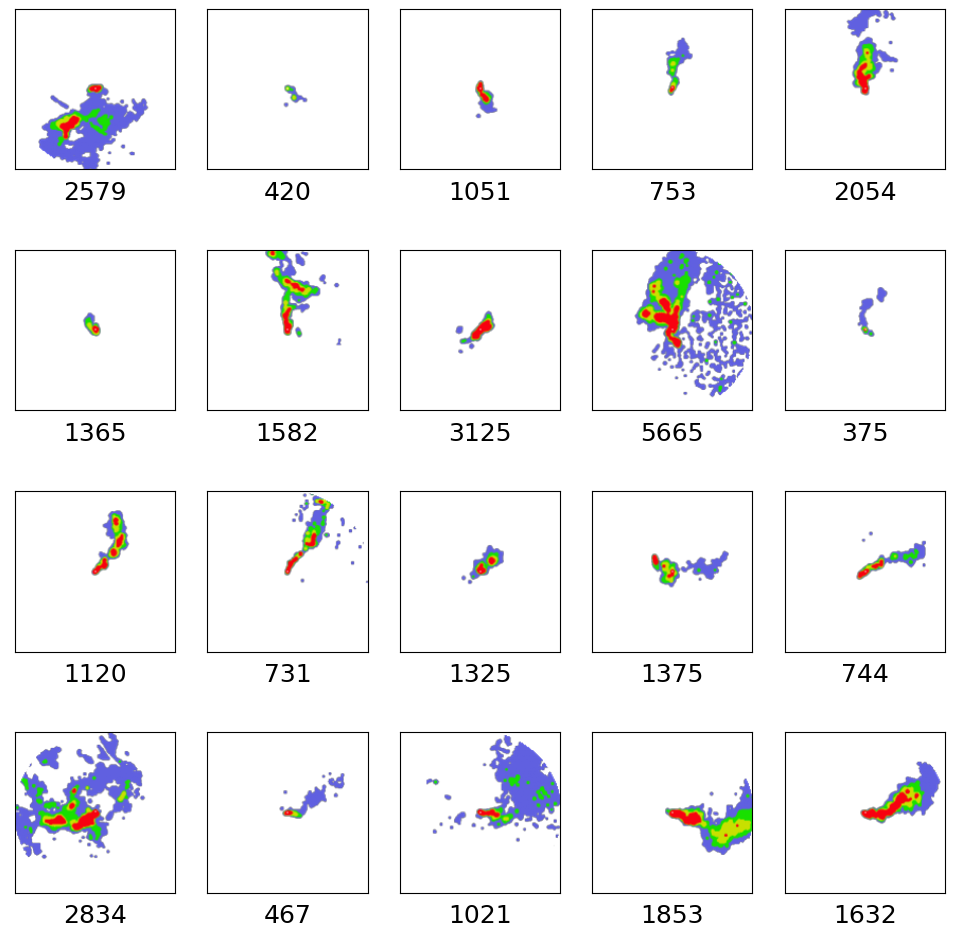

In [218]:
# Preview 20 images
print('Image Preview and Plume Rate')
plt.figure(figsize=(12,12))

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_set[i])
    plt.xlabel(str(int(reduced_plume['qplume'].loc[i])), fontsize = 18 )

plt.show()

## Model definition and training

In [220]:
# Defining the network used
from tensorflow.keras import layers

regressor = Sequential()
regressor.add(layers.RandomFlip("horizontal_and_vertical"))
regressor.add(layers.RandomRotation(0.2))
regressor.add(Conv2D(64, (3, 3), input_shape = (160, 160, 4), activation = 'relu'))
regressor.add(MaxPooling2D(pool_size = (2, 2)))
regressor.add(Conv2D(32, (3, 3), activation = 'relu'))
regressor.add(MaxPooling2D(pool_size = (2, 2)))
regressor.add(Conv2D(16, (3, 3), activation = 'relu'))
regressor.add(MaxPooling2D(pool_size = (2, 2)))
regressor.add(Conv2D(8, (3, 3), activation = 'relu'))
regressor.add(MaxPooling2D(pool_size = (2, 2)))
regressor.add(Flatten())
regressor.add(Dense(units = 128, activation = 'relu'))
regressor.add(Dropout(0.25))
regressor.add(Dense(units = 128, activation = 'linear'))
regressor.add(Dense(units = 3, activation = 'linear'))
regressor.add(Dense(units = 1, activation = 'linear'))


In [221]:
#Compile
regressor.compile(optimizer = 'adam', loss = 'MSE', metrics = ['mean_absolute_percentage_error'])

In [222]:
# Add liveloss plot as a callbacks to monitor progress when fitting below
import livelossplot
from keras.callbacks import EarlyStopping, ModelCheckpoint
live_plot = livelossplot.PlotLossesKeras()

early_stop = EarlyStopping(monitor='val_loss', patience=30, 
                           verbose=0, mode='auto', baseline=None, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath = 'Reduced_PlumeOnly_CNN_Rev13_preScld_MinMax_4CV2_4D_DO_25_adam_weights.h5',
                                  save_weights_only=True, monitor = 'loss', mode = 'min', save_best_only=True)

In [223]:
min(y), max(y)

(array([0.]), array([1.]))

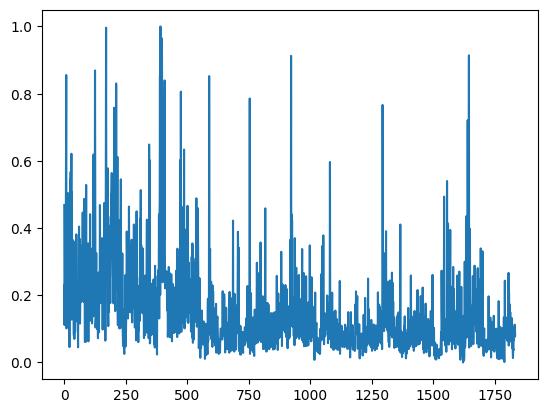

In [224]:
plt.plot(y)
plt.show()

In [225]:
from sklearn.model_selection import train_test_split

In [226]:
# Build train and test set from the undersampled image dataset (test and validation at 469 leaves 1024 for training)
x_train, x_test, y_train, y_test, bin_train, bin_test = train_test_split(image_set, y, q_bin, stratify = q_bin, test_size = 0.25, random_state = 8)

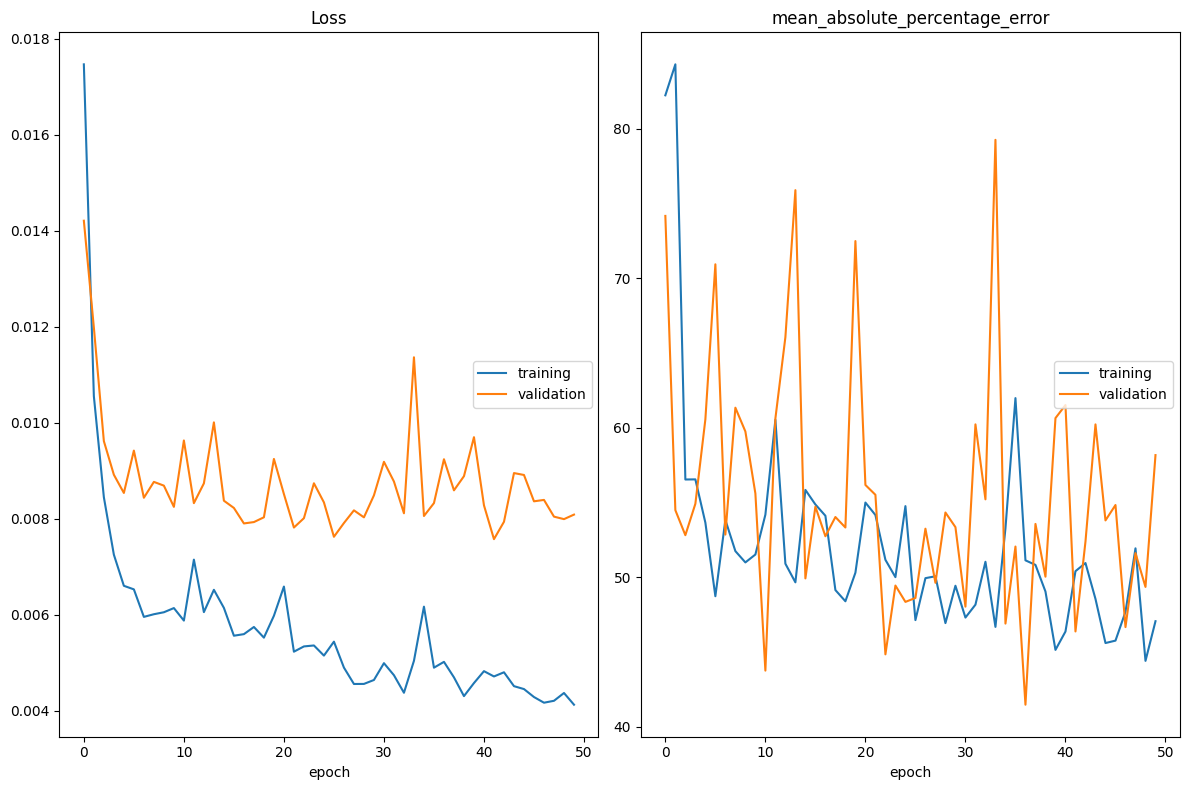

Loss
	training         	 (min:    0.004, max:    0.017, cur:    0.004)
	validation       	 (min:    0.008, max:    0.014, cur:    0.008)
mean_absolute_percentage_error
	training         	 (min:   44.411, max:   84.301, cur:   47.062)
	validation       	 (min:   41.478, max:   79.254, cur:   58.170)
8/8 [==============================] - 3s 403ms/step - loss: 0.0041 - mean_absolute_percentage_error: 47.0625 - val_loss: 0.0081 - val_mean_absolute_percentage_error: 58.1700


In [227]:
# Fit the model & train for 10 epochs initially, livelossplot in callbacks, validation split 
# and higher batch size to improve speed
regressor.fit(x_train, y_train, validation_split = 0.33, 
          callbacks = [live_plot, early_stop, model_checkpoint], initial_epoch = 0, epochs = 50, batch_size = 128)

In [228]:
regressor.save('CTRReduced_PlumeOnly_CNN_Rev13CTR_preScld_MinMax_4CV2_4D_DO_25_adam.h5')

## Testing the model

In [229]:
# Trying some predictions
ypred = regressor.predict(x_test)
min(ypred), max(ypred)

15/15 [==============================] - 0s 12ms/step


(array([0.05601513], dtype=float32), array([0.8487087], dtype=float32))

In [230]:
ypred[0:5]

array([[0.07380787],
       [0.11884462],
       [0.07855989],
       [0.06196488],
       [0.1382265 ]], dtype=float32)

In [231]:
y_test[0:5]

array([[0.03989391],
       [0.12663873],
       [0.09355449],
       [0.04047254],
       [0.10113051]])

In [232]:
# Scaling back predictions to get the actual estimated rates.
ypred_scld = np.power(scaler.inverse_transform(ypred), (4/3) )
ytest_scld = np.power(scaler.inverse_transform(y_test), (4/3) )
ypred_scld[0:5]

array([[259.03445],
       [454.71445],
       [278.34335],
       [212.4809 ],
       [546.695  ]], dtype=float32)

In [233]:
min(ypred_scld), max(ypred_scld)

(array([189.99289], dtype=float32), array([5606.121], dtype=float32))

In [234]:
ytest_scld[0:5]

array([[132.4336272],
       [491.1926159],
       [341.4535813],
       [134.4074175],
       [374.5252723]])

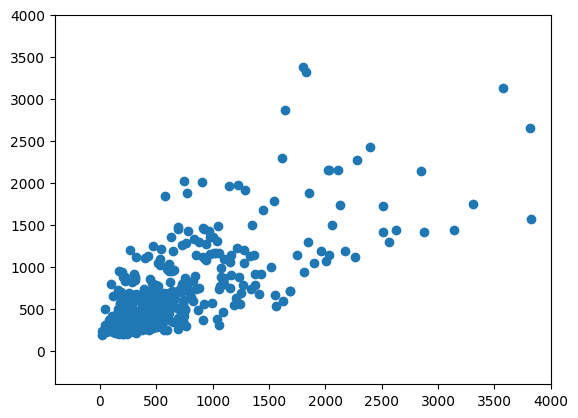

In [235]:
# Plotting the distribution of the tested values
plt.scatter( x = ytest_scld, y = ypred_scld)
#plt.scatter( x = [0,4000], y = [0,4000], linestyle_str = '-')
plt.xlim(-400, 4000)
plt.ylim(-400, 4000)
plt.show()

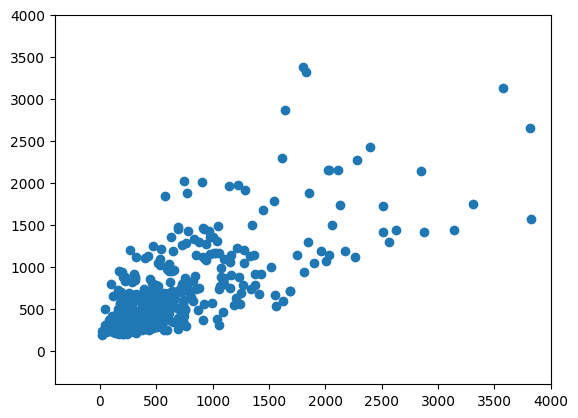

In [236]:
plt.scatter( x = ytest_scld, y = ypred_scld)
#plt.scatter( x = [0,4000], y = [0,4000], linestyle_str = '-')
plt.xlim(-400, 4000)
plt.ylim(-400, 4000)
plt.show()

In [237]:
ytrain = (regressor.predict(x_train))
ytrain[0:5]

43/43 [==============================] - 0s 11ms/step


array([[0.10722055],
       [0.07394101],
       [0.11646073],
       [0.08146947],
       [0.11578891]], dtype=float32)

In [238]:
min(ytrain), max(ytrain)

(array([0.03698213], dtype=float32), array([0.7753461], dtype=float32))

In [239]:
predtrain_scld = np.power(scaler.inverse_transform(ytrain), (4/3) )
y_train_scld = np.power(scaler.inverse_transform(y_train), (4/3) )
predtrain_scld[0:5]

array([[401.6536 ],
       [259.57068],
       [443.69934],
       [290.33487],
       [440.6073 ]], dtype=float32)

In [240]:
y_train_scld[0:5]

array([[204.1318507],
       [172.0122125],
       [269.6904103],
       [125.8877564],
       [311.7936129]])

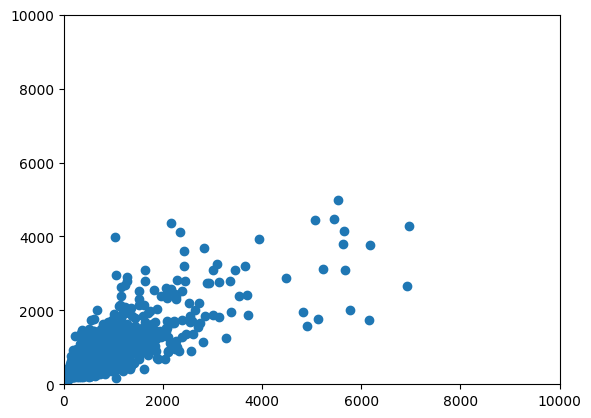

In [241]:
plt.scatter( x = y_train_scld, y = predtrain_scld)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.show()

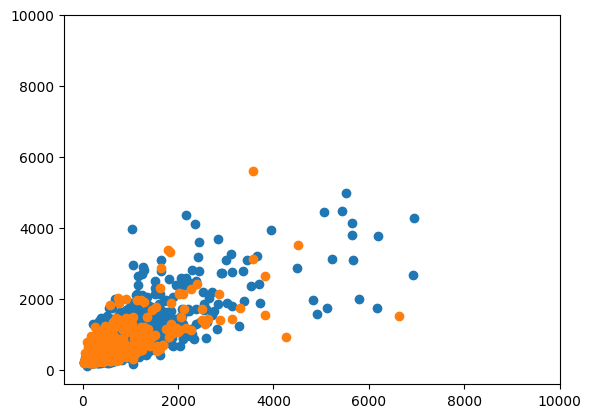

In [242]:
# Plotting ground truth and predicted values on the training set for reference
plt.scatter( x = y_train_scld, y = predtrain_scld)
plt.scatter( x = ytest_scld, y = ypred_scld)
plt.xlim(-400, 10000)
plt.ylim(-400, 10000)
plt.show()

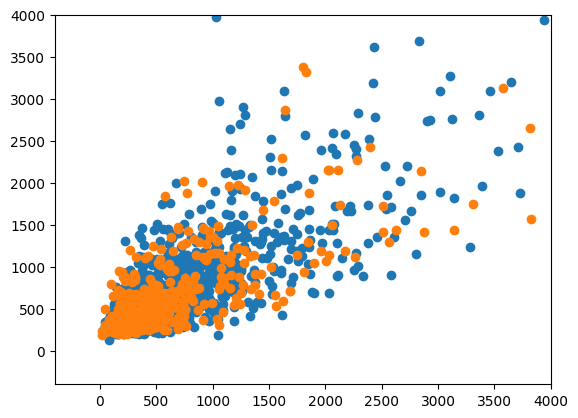

In [243]:
plt.scatter( x = y_train_scld, y = predtrain_scld)
plt.scatter( x = ytest_scld, y = ypred_scld)
plt.xlim(-400, 4000)
plt.ylim(-400, 4000)
plt.show()

In [244]:
import random
from sklearn.metrics import mean_squared_error as mse

In [245]:
val = mse(ytest_scld[0:20], ypred_scld[0:20], squared = False)
print("First 20 predicstions have RMSE of ", int(val))

First 20 predicstions have RMSE of  453


Image Preview of First 20 Test Set Images with Plume Rate & Predicted Plume Rate
1/1 [==============================] - 0s 130ms/step


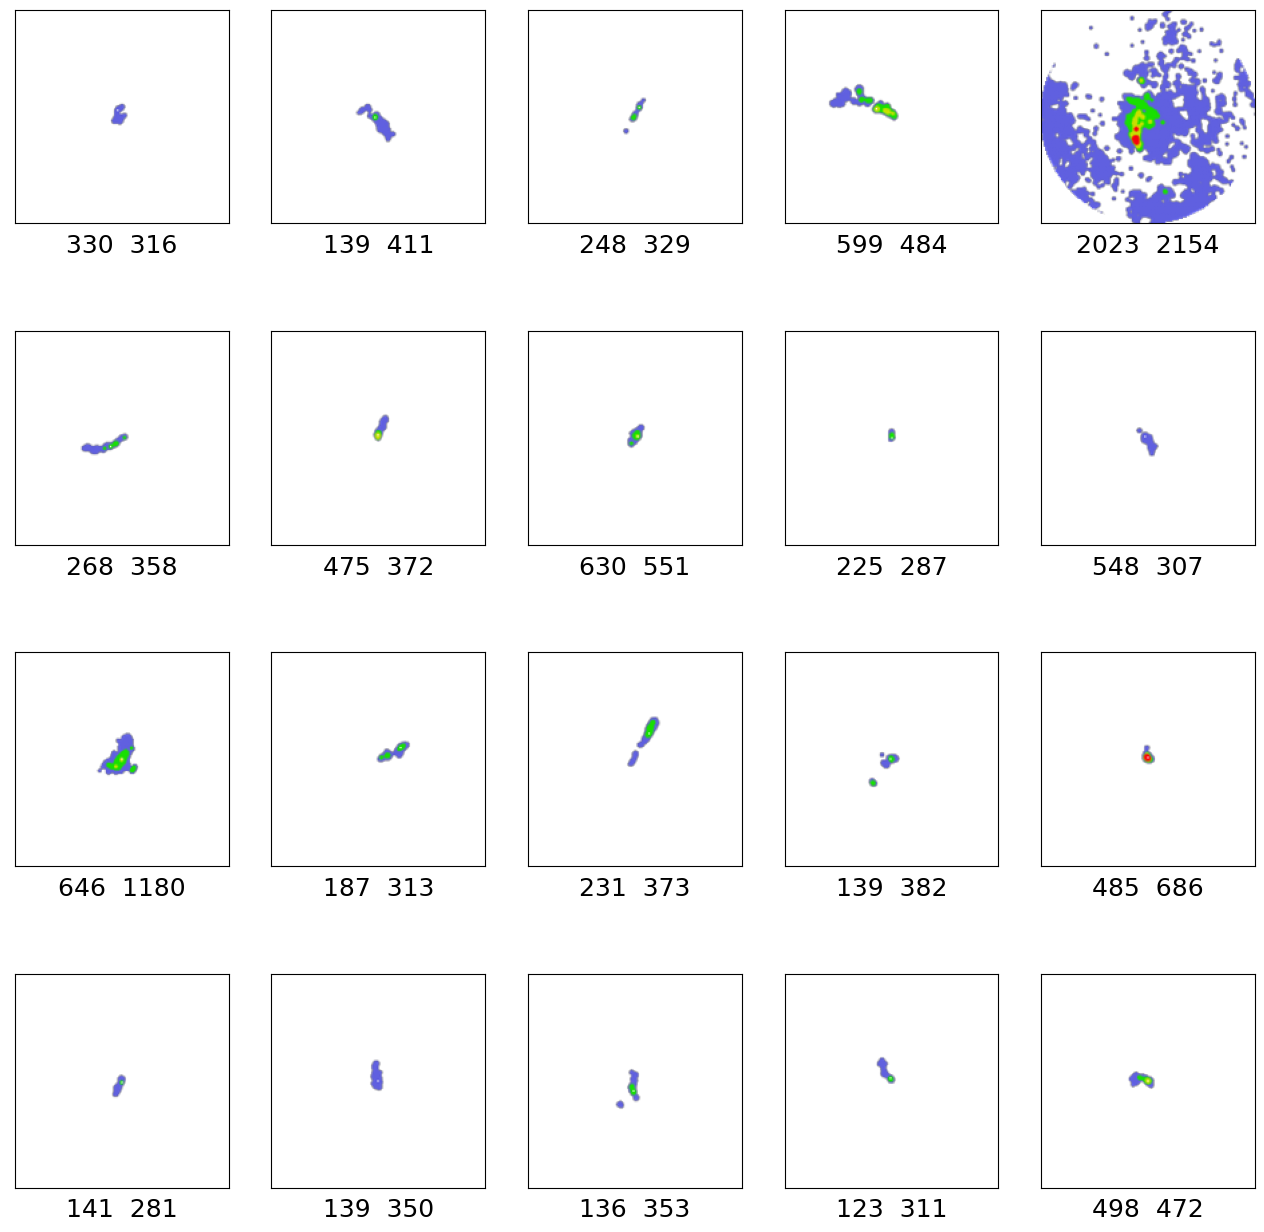

In [246]:
# Preview 20 images with ground truth and predicted values
offset = 80
a = offset
b = offset + 20
print('Image Preview of First 20 Test Set Images with Plume Rate & Predicted Plume Rate')
plt.figure(figsize=(16,16))
pred20 = abs(regressor.predict(x_test[a:b]))
pred20_scld = np.power(scaler.inverse_transform(pred20), (4/3) )
Y_test = np.power(scaler.inverse_transform(y_test[a:b]), (4/3) )
for i in range(20):  
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[a+i])
    plt.xlabel(str(int(Y_test[i])) + '  ' + str(int(pred20_scld[i])), fontsize = 18 ) 

plt.show()

In [247]:
# Calculate RMSE of 20 randomly selected groups of 20 images 
L = len(ypred_scld)
Sample_Range_RMSE = []
Sample_Image_Index = []
for j in range(20):
    rs = random.randint(0, L - 20) 
    val = mse(ytest_scld[rs:rs+20], ypred_scld[rs:rs+20], squared = False)
    Sample_Image_Index.append(rs)
    Sample_Range_RMSE.append(int(val))
print(Sample_Image_Index, '\n', Sample_Range_RMSE)
print(min(Sample_Range_RMSE), max(Sample_Range_RMSE))

[179, 126, 196, 421, 146, 2, 6, 72, 26, 176, 19, 414, 297, 289, 109, 373, 132, 248, 439, 80] 
 [408, 291, 300, 851, 452, 465, 480, 217, 438, 411, 364, 848, 1205, 462, 615, 424, 367, 587, 293, 195]
195 1205


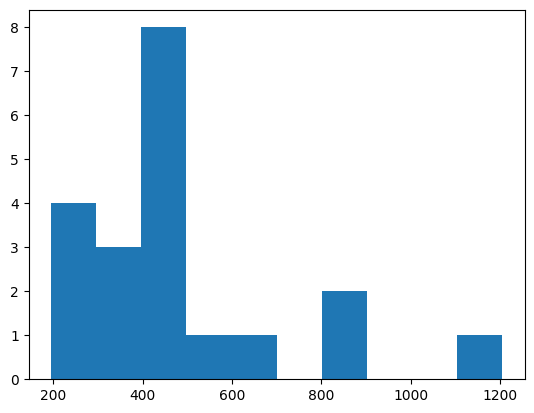

In [248]:
plt.hist(Sample_Range_RMSE, bins = 10)
plt.show()

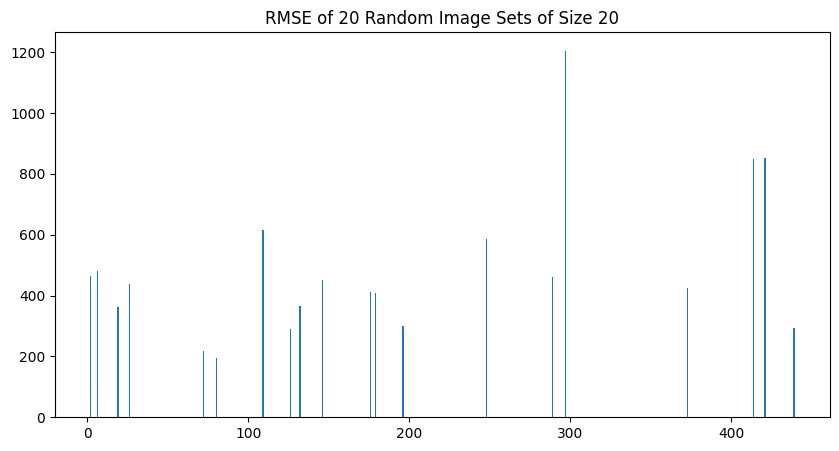

In [249]:
plt.figure(figsize=(10,5))
plt.title('RMSE of 20 Random Image Sets of Size 20')
plt.bar(x = Sample_Image_Index, height = Sample_Range_RMSE ) 
plt.show()

Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands and with Reduced Set of Q & Sigma Bands


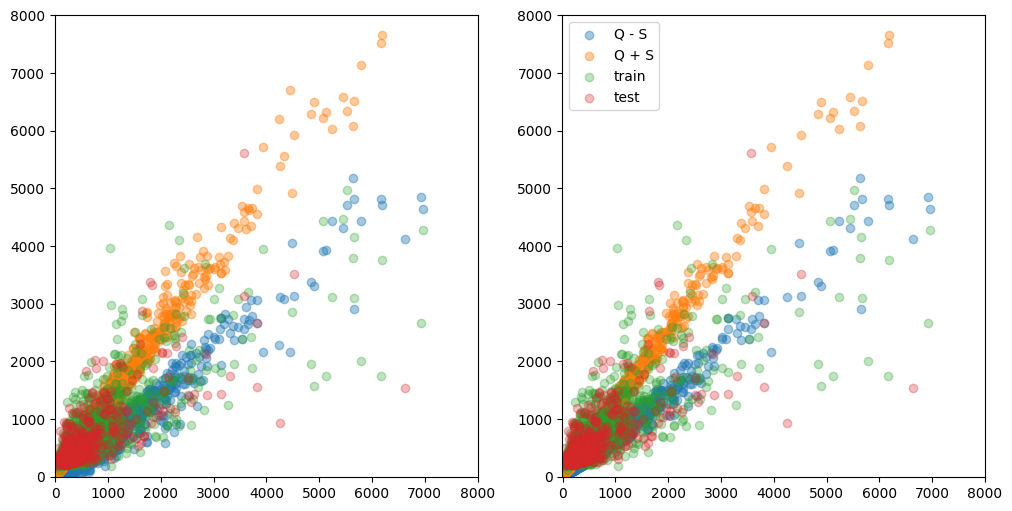

In [250]:
print('Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands and with Reduced Set of Q & Sigma Bands')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter( x = plume_list['qplume'], y = plume_list['qplume'] - plume_list['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = plume_list['qplume'], y = plume_list['qplume'] + plume_list['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q + S')
plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, label = 'test')
plt.xlim(-10, 8000)
plt.ylim(-10, 8000)
plt.subplot(1,2,2)
plt.scatter( x = reduced_plume['qplume'], y = reduced_plume['qplume'] - reduced_plume['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = reduced_plume['qplume'], y = reduced_plume['qplume'] + reduced_plume['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q + S')
plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, label = 'test')
plt.xlim(-10, 8000)
plt.ylim(-10, 8000)
plt.legend()
plt.show()

Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands and with Reduced Set of Q & Sigma Bands


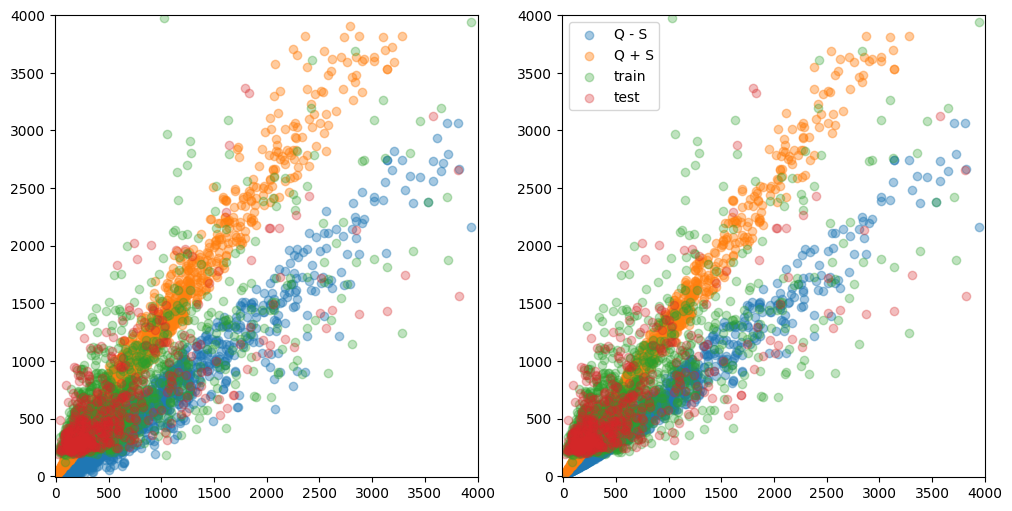

In [251]:
print('Predicted Q vs Actual Q with All Dataset Q +/- Sigma Bands and with Reduced Set of Q & Sigma Bands')
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.scatter( x = plume_list['qplume'], y = plume_list['qplume'] - plume_list['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = plume_list['qplume'], y = plume_list['qplume'] + plume_list['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q + S')
plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, label = 'test')
plt.xlim(-10, 4000)
plt.ylim(-10, 4000)
plt.subplot(1,2,2)
plt.scatter( x = reduced_plume['qplume'], y = reduced_plume['qplume'] - reduced_plume['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q - S')
plt.scatter( x = reduced_plume['qplume'], y = reduced_plume['qplume'] + reduced_plume['sigma_qplume'], marker = 'o', alpha = 0.4, label = 'Q + S')
plt.scatter( x = y_train_scld, y = predtrain_scld, marker = 'o', alpha = 0.3, label = 'train')
plt.scatter( x = ytest_scld, y = ypred_scld, marker = 'o', alpha = 0.3, label = 'test')
plt.xlim(-10, 4000)
plt.ylim(-10, 4000)
plt.legend()
plt.show()

In [252]:
Results = pd.read_csv('sample_submission_sample2.csv')
Folder_Path = 'test_files_raster_2/'


In [253]:
Results.head()

,source_ID,MethaneRate_Actual
0,01A,NaN
1,02A,NaN
2,03A,NaN
3,04A,NaN
4,05A,NaN


In [254]:
NumImages = Results.shape[0]
image_set = np.zeros((NumImages,160,160,4))

In [255]:
def Load_and_Resize(Fpath, size):
    img = Image.open(Fpath) 
    img = img.resize(size)
    img = np.asarray(img)/255
    return img


## Submission

In [256]:
# Generate some submission
# Read image files into the np array
size = (160,160)
for j in range(NumImages):
    print(j)
    if j <9 :
        Fpath = Folder_Path + Results['source_ID'].loc[j][1:]+"_ctr_rotated.tif"
    else:
        Fpath = Folder_Path + Results['source_ID'].loc[j]+"_ctr.tif"

    image_set[j] = Load_and_Resize(Fpath, size)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [257]:
image_set.shape

(20, 160, 160, 4)

Image Preview


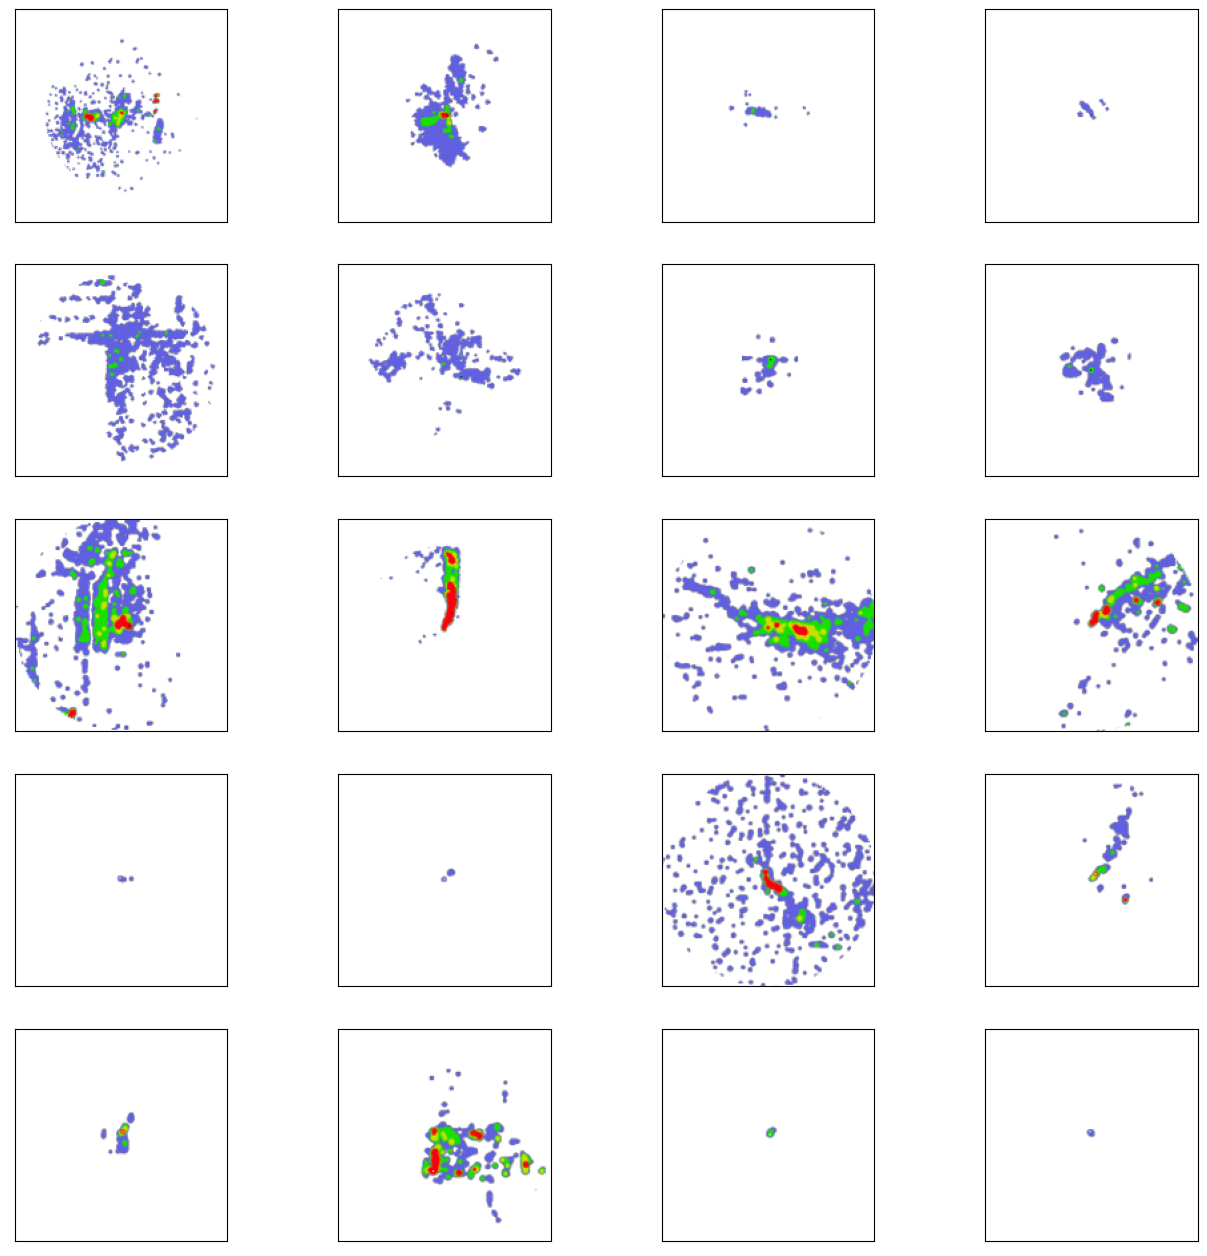

In [258]:
print('Image Preview')
plt.figure(figsize=(16,16))

for i in range(len(image_set)):  
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_set[i])
    #plt.xlabel(str(int(plume_list['qplume'].loc[i])), fontsize = 24 )

plt.show()

In [259]:
ypred = abs(regressor.predict(image_set))
ypred

1/1 [==============================] - 0s 33ms/step


array([[0.15377071],
       [0.24851486],
       [0.08042697],
       [0.07857296],
       [0.10005289],
       [0.05978253],
       [0.15454221],
       [0.17728245],
       [0.35668778],
       [0.30291748],
       [0.29651576],
       [0.1203006 ],
       [0.06063861],
       [0.06574909],
       [0.23099427],
       [0.08443507],
       [0.17538013],
       [0.2808914 ],
       [0.08809545],
       [0.07011777]], dtype=float32)

In [260]:
ypred_scld = np.power(scaler.inverse_transform(ypred),4/3)
ypred_scld

array([[ 623.4075 ],
       [1139.1475 ],
       [ 286.0238 ],
       [ 278.3969 ],
       [ 369.77478],
       [ 204.15953],
       [ 627.27966],
       [ 744.0286 ],
       [1810.102  ],
       [1466.9375 ],
       [1427.3082 ],
       [ 461.47513],
       [ 207.41393],
       [ 227.10432],
       [1038.1483 ],
       [ 302.68604],
       [ 734.0735 ],
       [1331.7422 ],
       [ 318.10617],
       [ 244.28357]], dtype=float32)

In [261]:
Results['MethaneRate_Actual'] = ypred_scld
Results

,source_ID,MethaneRate_Actual
0,01A,623.407471
1,02A,1139.147461
2,03A,286.023804
3,04A,278.396912
4,05A,369.774780
5,06A,204.159531
6,07A,627.279663
7,08A,744.028625
8,09A,1810.102051
9,10A,1466.937500


In [262]:
Results.to_csv('DreamTeam_CTR_Subm2_Model_13_Rev1.csv', index = False)